In [1]:
import pandas as pd
import numpy as np

In [2]:
data_set_test = pd.read_csv('test.csv')
data_set_train = pd.read_csv('training.csv')
data_set_validation = pd.read_csv('validation.csv')

df = pd.concat([data_set_train, data_set_validation, data_set_test], ignore_index=True)

## Análisis de los datos

In [3]:
df.head()

text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

In [4]:
df.describe()

label
count  20000.000000
mean       1.562850
std        1.496684
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [6]:
df.isnull().sum()

text     0
label    0
dtype: int64

<Axes: xlabel='label'>

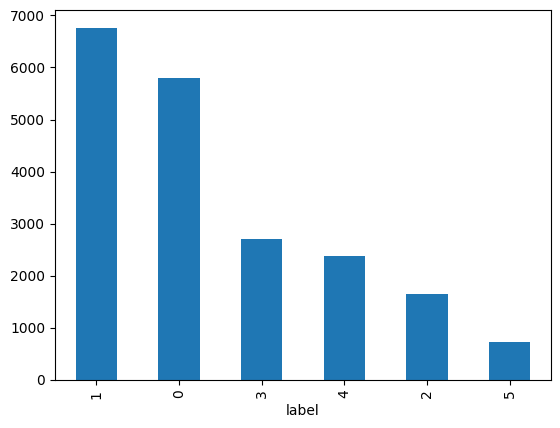

In [13]:
df['label'].value_counts().plot(kind='bar')

In [10]:
import seaborn as sns

Hay un notable desbalance
sadness (0), joy (1), love (2), anger (3), fear (4).

## Procesamiento de los datos
Este dataset ya se encontraba preprocesado, por lo que solo se realizará tokenización, lemmatization y vectorización

In [20]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
stop_words_en = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly_express as px
import spacy
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jyaruhernandez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jyaruhernandez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jyaruhernandez/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jyaruhernandez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
text = "hi good morning i am really sad"

In [22]:
def vectorize(text):
    text = word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words_en]
    text = ' '.join(text)
    text = nlp(text)
    return text.vector

In [23]:
df['vector'] = df['text'].apply(vectorize)

In [24]:
X = df['vector']

In [25]:
X = np.concatenate(X).reshape(-1,300)

In [26]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import seaborn as sns

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

In [28]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
y_train = to_categorical(y_train,6)
y_test = to_categorical(y_test,6)

In [30]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
model = Sequential()

In [32]:
X_train.shape[1]

300

In [47]:
from sklearn.manifold import TSNE
import plotly_express as px

modelo = TSNE(n_components=2)
resultado = modelo.fit_transform(X)
df['tsne_1'] = resultado[:,0]
df['tsne_2'] = resultado[:,1]

fig = px.scatter(df, x="tsne_1", y="tsne_2", color=df["label"], hover_data=['text'], 
                 template='plotly_dark')
fig.show()

In [33]:
model.add(Conv1D(64,5,activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
from tensorflow.keras.utils import plot_model

In [46]:
history = model.fit(X_train, y_train, epochs=300, batch_size=35, validation_data=[X_test,y_test], callbacks=[early_stopping])

Epoch 1/300
458/458 [==============================] - 2s 3ms/step - loss: 1.7528 - accuracy: 0.3421 - val_loss: 1.6603 - val_accuracy: 0.4338
Epoch 2/300
458/458 [==============================] - 2s 3ms/step - loss: 1.6803 - accuracy: 0.3931 - val_loss: 1.6257 - val_accuracy: 0.4400
Epoch 3/300
458/458 [==============================] - 2s 3ms/step - loss: 1.6499 - accuracy: 0.4058 - val_loss: 1.6020 - val_accuracy: 0.4518
Epoch 4/300
458/458 [==============================] - 1s 3ms/step - loss: 1.6285 - accuracy: 0.4233 - val_loss: 1.5815 - val_accuracy: 0.4577
Epoch 5/300
458/458 [==============================] - 2s 3ms/step - loss: 1.6055 - accuracy: 0.4353 - val_loss: 1.5591 - val_accuracy: 0.4660
Epoch 6/300
458/458 [==============================] - 2s 3ms/step - loss: 1.5862 - accuracy: 0.4390 - val_loss: 1.5416 - val_accuracy: 0.4697
Epoch 7/300
458/458 [==============================] - 1s 3ms/step - loss: 1.5746 - accuracy: 0.4434 - val_loss: 1.5271 - val_accuracy: 0.4755

KeyboardInterrupt: 

In [ ]:
history_df = pd.DataFrame(history.history)

<Axes: >

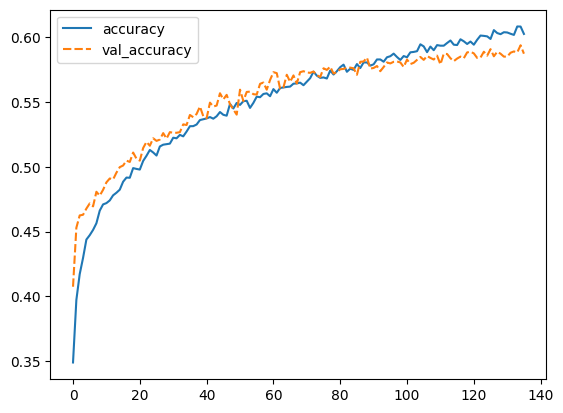

In [25]:
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])

In [26]:
model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 1ms/step - loss: 1.1891 - accuracy: 0.5872


[1.1891260147094727, 0.5872499942779541]

In [27]:
from sklearn.metrics import classification_report

In [28]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

125/125 [==============================] - 0s 1ms/step


In [29]:
y_test = np.argmax(y_test, axis=-1)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.78      0.64      1159
           1       0.64      0.77      0.70      1352
           2       0.62      0.22      0.32       328
           3       0.59      0.31      0.40       542
           4       0.53      0.34      0.42       475
           5       0.80      0.03      0.05       144

    accuracy                           0.59      4000
   macro avg       0.62      0.41      0.42      4000
weighted avg       0.60      0.59      0.55      4000



In [31]:
def clasifica_texto(texto):
    vector = vectorize(texto)
    vector = vector.reshape(1,300,1)
    return np.argmax(model.predict(vector), axis=-1)

In [33]:
clasifica_texto("i think life is painful")

1/1 [==============================] - 0s 11ms/step


array([0])

In [47]:
model.save('model_emotion.h5')

/Users/jyaruhernandez/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
#read model
from tensorflow.keras.models import load_model
model = load_model('model_emotion.h5')